In [1]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import os
import math
#import imageio
from scipy.ndimage.interpolation import map_coordinates
from pprint import pprint
import glob
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator
from copy import copy
from copy import deepcopy
#from mpl_toolkits.axes_grid1 import make
#_axes_locatable
%matplotlib inline
from scipy import stats
import multiprocessing as mp
import matplotlib.patches as patches

In [2]:
_wbgyr_cdict = {'red': ((0.0,  255./255, 255./255),
                        (0.125, 173./255, 173./255),
                        (0.25,  95./255,  95./255),
                        (0.375, 73./255,  73./255),
                        (0.5,  165./255, 164./255),
                        (0.625, 248./255, 248./255),
                        (0.75, 236./255, 236./255),
                        (0.875, 200./255, 200./255),
                        (1.0,  146./255, 146./255)),
                'green': ((0.0,  255./255, 255./255),
                          (0.125, 224./255, 224./255),
                          (0.25, 163./255, 163./255),
                          (0.375, 166./255, 166./255),
                          (0.5,  207./255, 207./255),
                          (0.625, 184./255, 184./255),
                          (0.75,  86./255,  86./255),
                          (0.875, 29./255,  29./255),
                          (1.0,   21./255,  21./255)),
                'blue': ((0.0,  255./255, 255./255),
                         (0.125, 248./255, 248./255),
                         (0.25, 214./255, 214./255),
                         (0.375, 120./255, 120./255),
                         (0.5,   81./255,  81./255),
                         (0.625, 73./255,  73./255),
                         (0.75,  41./255,  41./255),
                         (0.875, 38./255,  38./255),
                         (1.0,   25./255,  25./255))}
# And reverse
_wbgyr_cdict_r = deepcopy(_wbgyr_cdict)
for i in _wbgyr_cdict_r.keys():
    _wbgyr_cdict_r[i] = [(1-j[0], j[1], j[2]) for j in _wbgyr_cdict_r[i]]
    _wbgyr_cdict_r[i].reverse()

cmap = LinearSegmentedColormap('WBGYR', _wbgyr_cdict)
cmap.set_bad('#D2D2D2')
plt.register_cmap(cmap=cmap)

cmap_r = LinearSegmentedColormap('WBGYR', _wbgyr_cdict_r)
cmap_r.set_bad('#D2D2D2')
plt.register_cmap(cmap=cmap_r)

In [ ]:
tsc = xr.open_mfdataset('/net/hardin/disk1/Users/gah20/TSC_2origin/200[0-2]/*.nc',combine='nested',concat_dim='time')

In [64]:
heatmap = np.zeros((3,7,36,60,360))
for year in range(2002,2003,1):
    tsc = xr.open_mfdataset('/net/hardin/disk1/Users/gah20/TSC_2origin/'+str(year)+'/*.nc',combine='nested',concat_dim='time')

    loclat = tsc['LocOrigin'][:,0,2:62]
    loclon = tsc['LocOrigin'][:,1,2:62]

    loclatnoconv = np.where(tsc['TSC'][:,2:62]==0,np.nan,loclat)
    loclonnoconv = np.where(tsc['TSC'][:,2:62]==0,np.nan,loclon)

    ilat = np.around(loclatnoconv/100)*10
    ilon = np.around(loclonnoconv/100)*10

    print(str(year)+' heatmap starting')
    for i in range(0,7,1):
        for j in range(0,36,1):
            heatmap[year-2000,i,j] = np.nansum(np.where((ilat[:]==i*10)&(ilon[:]==j*10),1,0),axis=0)

2002 heatmap starting


/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


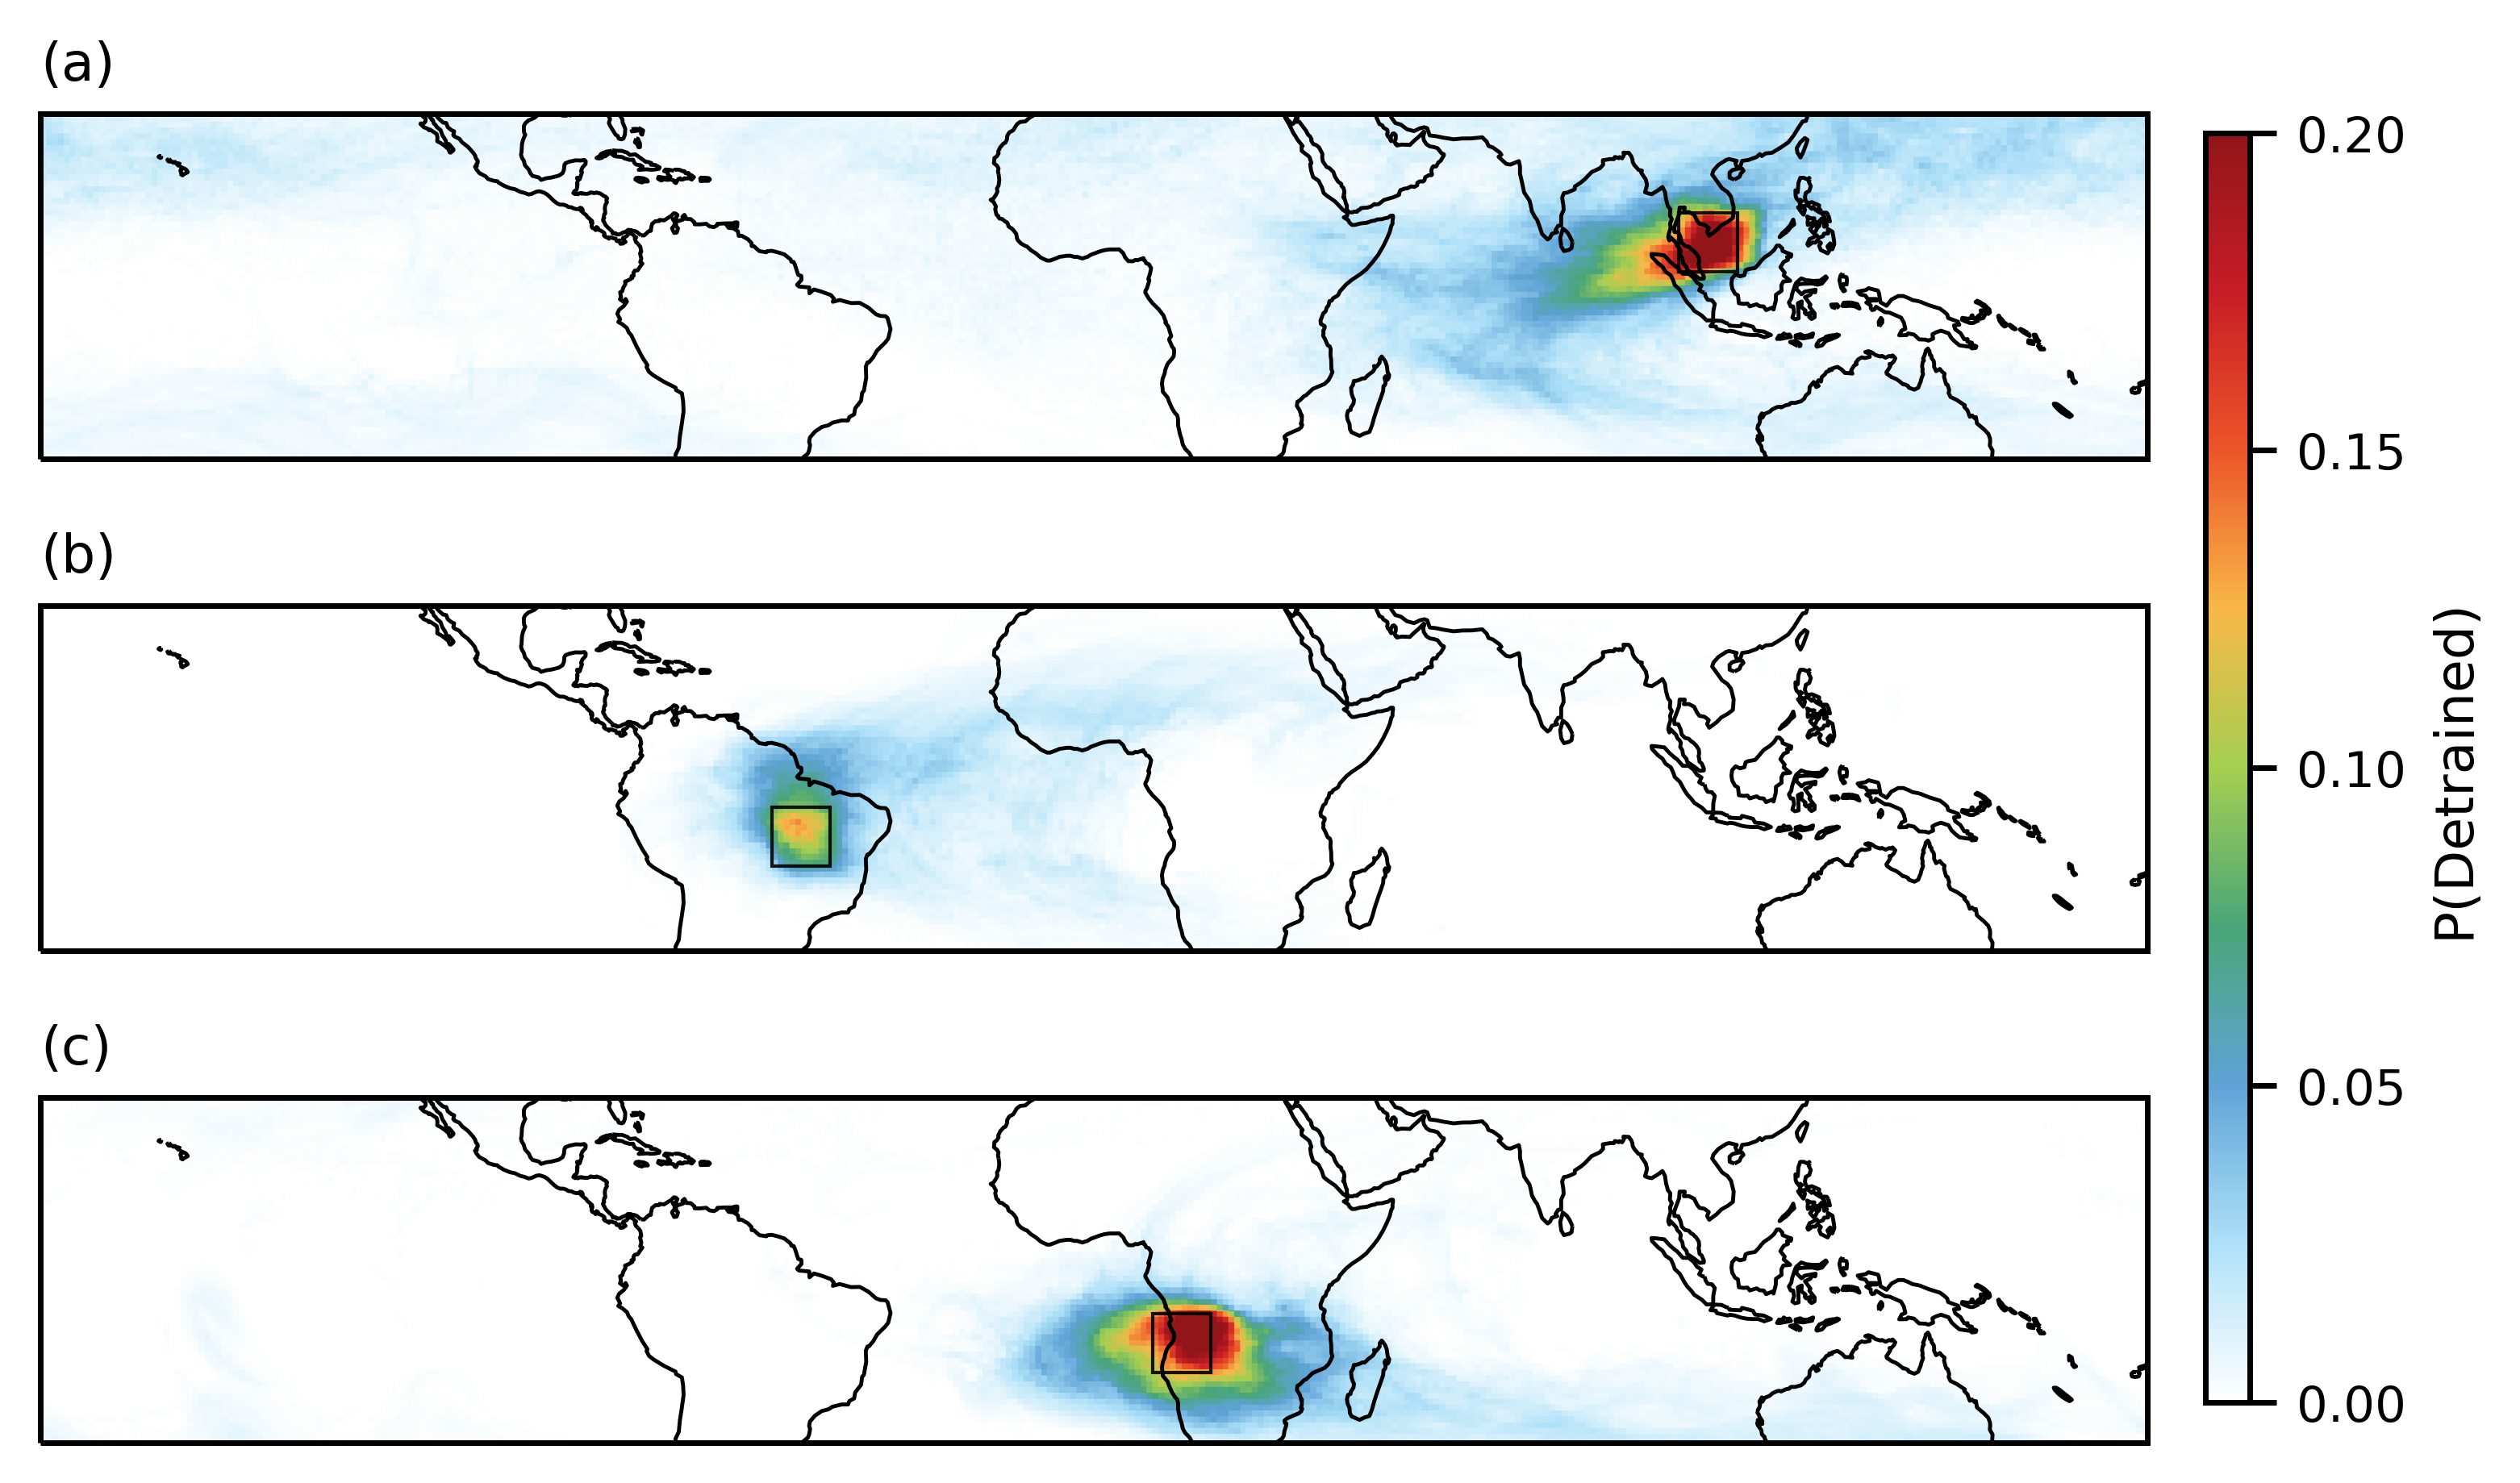

In [90]:
frac = 0.2245
pa = 0.04
cm = 1/2.54 
import seaborn as sns
img_extent = (-180, 180, -30, 30)
sns.set_context('paper')
fig = plt.figure(figsize=(14*cm,10*cm),dpi=500)
gs = fig.add_gridspec(3, 1)

ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree())


ax0.set_extent([-180,180,-29.5,29.5],ccrs.PlateCarree())
ax0.coastlines(resolution='auto', color='k',linewidth=0.7)
im0 = ax0.imshow(heatmap[2,4,11]/8760,origin='lower',extent=img_extent,cmap=cmap,transform=ccrs.PlateCarree(central_longitude=180),vmin=0,vmax=0.2)

ax1.set_extent([-180,180,-29.5,29.5],ccrs.PlateCarree())
ax1.coastlines(resolution='auto', color='k',linewidth=0.7)
im1 = ax1.imshow(heatmap[2,2,31]/8760,origin='lower',extent=img_extent,cmap=cmap,vmax=0.25,vmin=0,transform=ccrs.PlateCarree(central_longitude=180))

ax2.set_extent([-180,180,-29.5,29.5],ccrs.PlateCarree())
ax2.coastlines(resolution='auto', color='k',linewidth=0.7)
im2 = ax2.imshow(heatmap[2,2,2]/8760,origin='lower',extent=img_extent,cmap=cmap,vmax=0.25,vmin=0,transform=ccrs.PlateCarree(central_longitude=180))

fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im0, cax=cbar_ax)
cbar.set_ticks([0,0.05,0.1,0.15,0.2])
cbar.set_label('P(Detrained)')

ax0.set_title('(a)',loc='left')
ax1.set_title('(b)',loc='left')
ax2.set_title('(c)',loc='left')



rect0 = patches.Rectangle((100, 2.5), 10, 10, linewidth=0.6,linestyle='-', edgecolor='k',alpha=0.9, facecolor='none')
ax0.add_patch(rect0)

rect1 = patches.Rectangle((-55, -15), 10, 10, linewidth=0.6,linestyle='-', edgecolor='k',alpha=0.9, facecolor='none')
ax1.add_patch(rect1)

rect2 = patches.Rectangle((10, -17.5), 10, 10, linewidth=0.6,linestyle='-', edgecolor='k',alpha=0.9, facecolor='none')
ax2.add_patch(rect2)
plt.tight_layout()
plt.savefig('/disk1/Users/gah20/SensitivityWork/PaperPlots/heatmap.png',dpi=500,bbox_inches='tight')


In [29]:
heatmap = np.load('/disk1/Users/gah20/Heatmaps/heatmap_1deg_d2000.npy')

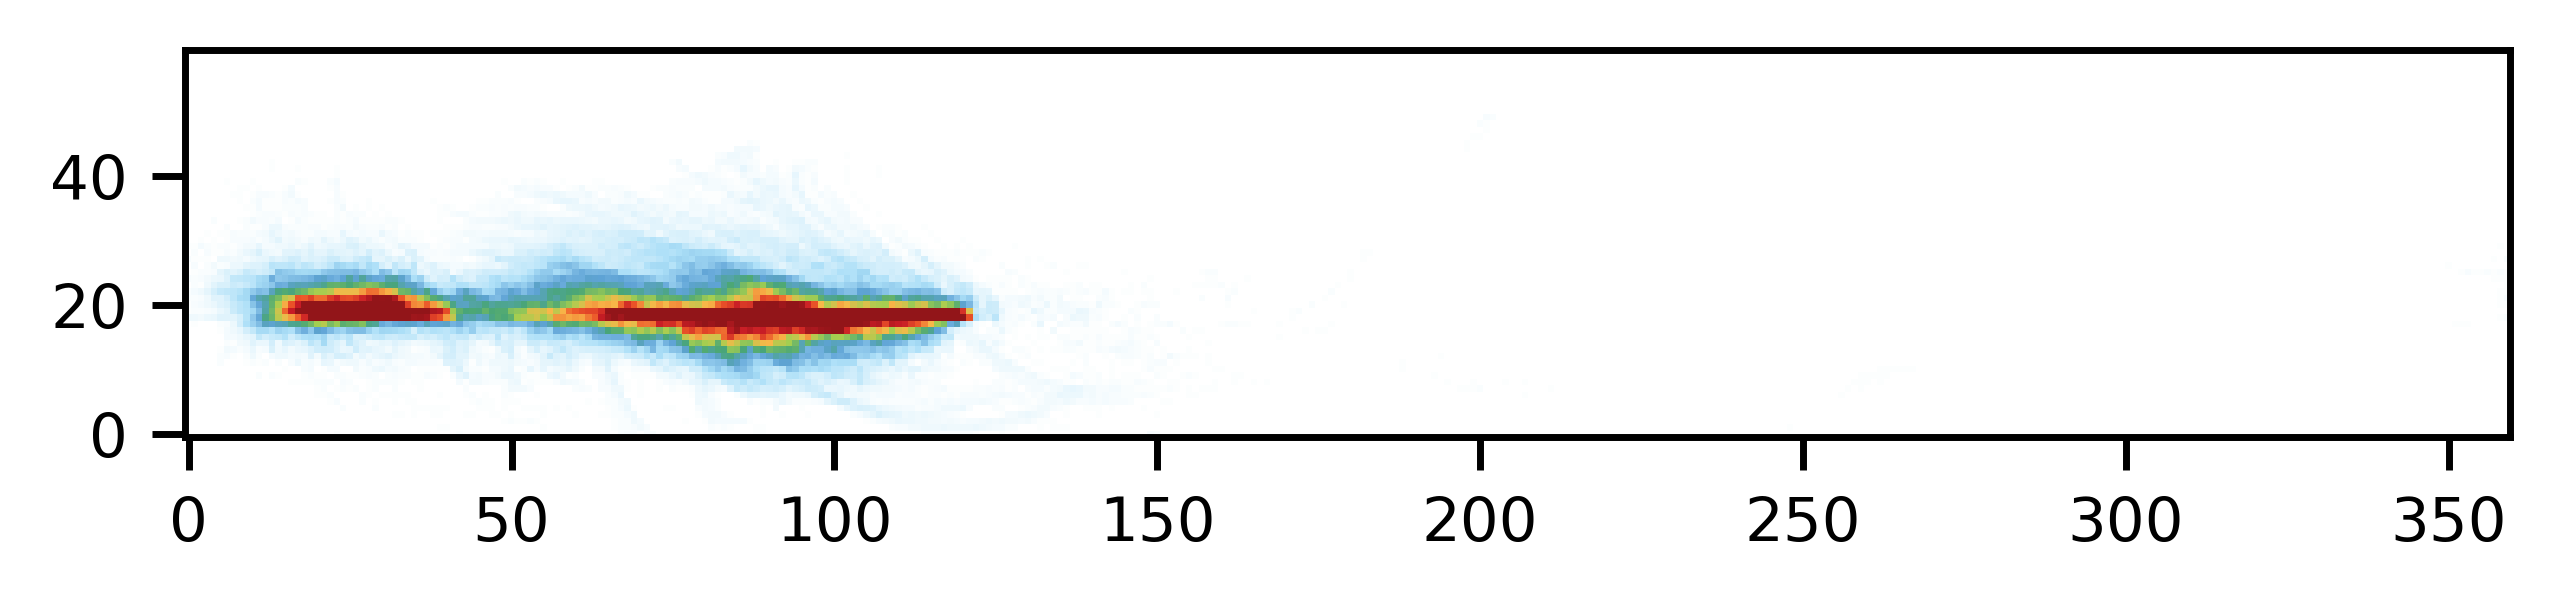

In [62]:
plt.figure(dpi=500)
plt.imshow(np.nansum(heatmap[20:22,20:122],axis=(0,1)),interpolation='none',origin='lower',cmap=cmap,vmax=500)